In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

import mpmath as mp
import math

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
import pandas as pd
from scipy import stats
import scipy
from scipy.optimize import minimize
from numpy import linalg as LA

from LGF_funcs import *
import time

# Comparing with asymptotic expansion at large c

In [4]:
mp.dps = 50

c_vec = [0.5, 0.75, 1, 1.5]
alpha = 0.75

n = 0
n_pts =10
n_sample = 5

distvec0 = np.random.choice(range(n_pts), n_sample, replace=False)
distvec1 = np.random.choice(range(n_pts), n_sample, replace=False)

marker_vec = ["x", "s","^","v", "+"]
#distvec = np.random.choice(range(n_pts), n_sample - 1, replace=False)
#distvec = np.append(distvec, n_sample)

N_vec_mat = np.zeros((len(c_vec), 9))
N_vec = np.arange(10, 55, 5) 
for i in range(len(c_vec)):
    for j in range(len(N_vec)):
        if (i == 0):
            N_vec_mat[i,j] = N_vec[j] * 2**(len(c_vec) - i - 2)
        else:
            N_vec_mat[i,j] = N_vec[j] * 2**(len(c_vec) - i - 1)

distvec = np.arange(0, n_sample)

vs = np.zeros((n_sample, len(c_vec)))
v_exp = np.zeros((n_sample, len(c_vec), len(N_vec)))
print(v_exp.shape)
for i in range(n_sample):
    tmp_n = distvec0[i]
    tmp_m = distvec1[i]

    for j in range(len(c_vec)):
        c = c_vec[j]
        eps = 1e-10
        lbd = 2 + 2*alpha
        c_ratio = lbd/(lbd+c**2)

        vv = eval_lgf_appell(c, tmp_n, tmp_m, alpha)
        vs[i,j] = vv
        for count in range(len(N_vec)):
            vv = eval_lgf_exp(c, tmp_n, tmp_m, alpha, int(N_vec_mat[j, count]))
            v_exp[i, j, count] = vv
            
    #vv = eval_lgf(0.002, 0, tmp_m, 100000)
    

#print(vs - v_exp)

(5, 4, 9)


<Figure size 640x480 with 0 Axes>

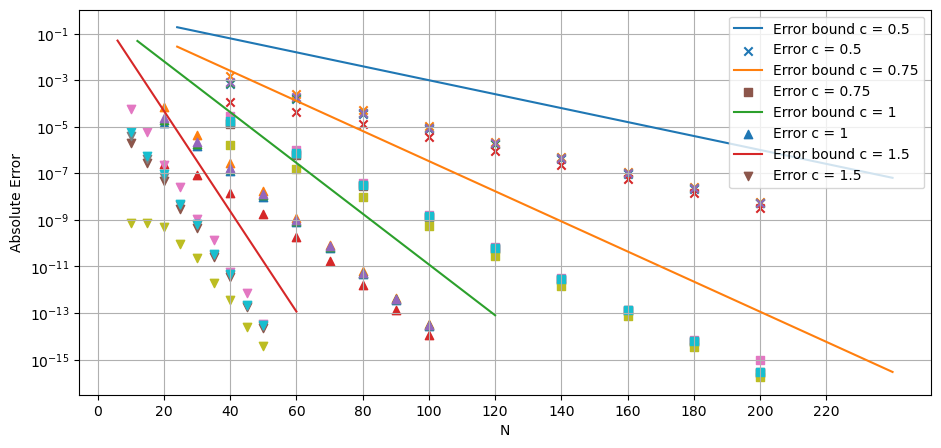

In [5]:
import matplotlib
from matplotlib.ticker import FormatStrFormatter
plt.clf()
fig = plt.figure(figsize=(11,5))
ax = plt.gca()



for i in range(len(c_vec)):
    N_vecc = np.linspace(N_vec_mat[i, 0]*0.6, N_vec_mat[i, -1]*1.2, 20)
    c = c_vec[i]
    lbd = 2 + 2*alpha
    c_ratio = lbd/(lbd+c**2)
    y = np.power(c_ratio, N_vecc)
    plt.semilogy(N_vecc, y, label='Error bound c = ' + str(c_vec[i]))
    for j in range(n_sample):
        diff = np.abs(v_exp[j, i, :] - vs[j,i])
        if (j == 0):
            plt.scatter(N_vec_mat[i, :], diff, label='Error c = ' + str(c_vec[i]), marker=marker_vec[i])
        else:
            plt.scatter(N_vec_mat[i, :], diff, label='_nolengend_' + str(c_vec[i]), marker=marker_vec[i])



# Customizing major grid lines (optional)
#plt.grid(which='major', linestyle='-', linewidth=0.75)
#plt.grid(which='minor', linestyle='-', linewidth=0.75)
            
plt.yscale('log')
plt.grid(which='both')
#plt.minorticks_on()

plt.xticks(np.arange(0,240,20))

locmajy = matplotlib.ticker.LogLocator(base=10,numticks=10) 
#locminy = matplotlib.ticker.LogLocator(base=10,subs=np.arange(0, 10, 2),numticks=100) # subs=(0.2,0.4,0.6,0.8)
locminy = matplotlib.ticker.LogLocator(base=10,subs=[2,5],numticks=100) # subs=(0.2,0.4,0.6,0.8)

#ax.yaxis.set_major_locator(locmajy)
#ax.yaxis.set_minor_locator(locminy)
#ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

plt.xlabel('N')
plt.ylabel('Absolute Error')
plt.legend()
plt.minorticks_off()






#plt.show()
#ax.yaxis.set_minor_formatter(FormatStrFormatter("%.6f"))

#matplotlib.axis.Axis.xaxis.set_minor_locator(mticker.LogLocator(base=2.0, subs=(0.1,0.2,0.4,0.6,0.8)))

#plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
#plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)

plt.savefig('error_bound_c_expension.pdf')

# Comparing with sufficient quadrature points trapzoidal rules 

In [8]:
def AssessingError(c, alpha, n, n_sample, n_pts = 1e10):
    distvec = np.random.choice(range(n_pts), n_sample, replace=False)
    vs = np.zeros(n_sample)
    for i in range(n_sample):
        tmp_m = distvec[i]
        #vv = eval_lgf(0.002, 0, tmp_m, 100000)
        vv = eval_lgf_appell(c, tmp_m, n, alpha)
        vs[i] = vv

    resv = eval_lgf_rfft(c, alpha, n, n_pts)

    fv = np.real(resv)
    fv_part = fv[distvec]

    diff = np.abs((fv_part - vs))

    true_idx = np.argsort(distvec)
    sortedv = diff[true_idx]
    sortedidx = distvec[true_idx]

    eta = c**2/alpha * (1 - 0.01)
    M_eta = 1/2/np.sqrt(c**2/alpha - eta)
    gamma_eta = np.log(1 + eta/2 + np.sqrt((1 + eta/2)**2 - 1))

    min_m = min(distvec)
    max_m = max(distvec)
    m_space = np.linspace(min_m, max_m, n_pts)
    print('M_eta is ',M_eta)
    err_est = 2*M_eta/np.exp((2*n_pts - m_space)*gamma_eta)


    plt.semilogy(sortedidx, sortedv,'-o')
    plt.semilogy(m_space, err_est)
    plt.legend(['Error', 'Error Bound'])

    plt.xlabel('m')
    plt.ylabel('Absolute Error')
    plt.grid(which='both')
    plt.minorticks_on()

M_eta is  16.666666666666686


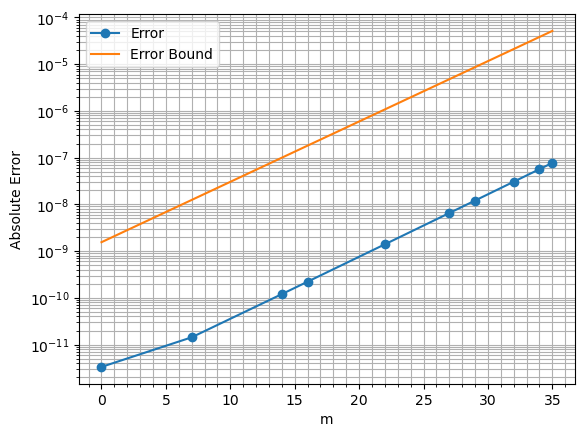

In [9]:
AssessingError(0.3, 1, 0, 10, 40)
#plt.savefig('Err_03_10_m_0_40_appell.png')

In [13]:
def AssessingErrorBatch(c_vec, alpha_vec, m_vec, n_sample, npts_vec):
    for l, n_pts in enumerate(npts_vec):
        
        for i, c in enumerate(c_vec):
            alpha = alpha_vec[i]
            plt.clf()
            plt.figure()
            max_n_all = 0
            min_n_all = n_pts+10
            
            
            for k, m in enumerate(m_vec):
                distvec = np.random.choice(range(n_pts), n_sample, replace=False)
                vs = np.zeros(n_sample)
                for i in range(n_sample):
                    tmp_n = distvec[i]
                    #vv = eval_lgf(0.002, 0, tmp_m, 100000)
                    vv = eval_lgf_appell(c, tmp_n, m, alpha)
                    vs[i] = vv

                resv = eval_lgf_rfft(c, alpha, m, n_pts)

                fv = np.real(resv)
                fv_part = fv[distvec]

                diff = np.abs((fv_part - vs))

                true_idx = np.argsort(distvec)
                sortedv = diff[true_idx]
                sortedidx = distvec[true_idx]

                eta = c**2/alpha * (1 - 0.01)**2
                M_eta = 1/2/np.sqrt(c**2/alpha - eta)
                gamma_eta = np.log(1 + eta/2 + np.sqrt((1 + eta/2)**2 - 1))

                min_n = min(distvec)
                max_n = max(distvec)

                if max_n > max_n_all:
                    max_n_all = max_n

                if min_n < min_n_all:
                    min_n_all = min_n
                
                print('M_eta is ',M_eta)
                name_str = "m = " + str(m)

                plt.semilogy(sortedidx, sortedv,'o',label=name_str)


            m_space = np.linspace(min_n_all, max_n_all, n_pts)
            eta = c**2/alpha * (1 - 0.01)**2
            M_eta = 1/2/np.sqrt(c**2/alpha - eta)
            gamma_eta = np.log(1 + eta/2 + np.sqrt((1 + eta/2)**2 - 1))

            err_est = 2*M_eta/np.exp((2*n_pts - m_space)*gamma_eta)
            plt.semilogy(m_space, err_est, label="error bound")
            plt.legend()
            plt.xlabel('n', fontsize=15)
            plt.ylabel(r'Absolute Error', fontsize=15)
            plt.grid(True, 'major')
            #plt.grid(True, 'both')
            plt.minorticks_off()
            figname_str = 'Appell_comparison/Appell_test_'+str(n_pts)+"_"+str(int(alpha*100))+".pdf"
            plt.savefig(figname_str)
                        

M_eta is  11.814686750138929
M_eta is  11.814686750138929
M_eta is  11.814686750138929
M_eta is  9.451749400111146
M_eta is  9.451749400111146
M_eta is  9.451749400111146
M_eta is  11.814686750138929
M_eta is  11.814686750138929
M_eta is  11.814686750138929
M_eta is  9.451749400111146
M_eta is  9.451749400111146
M_eta is  9.451749400111146


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

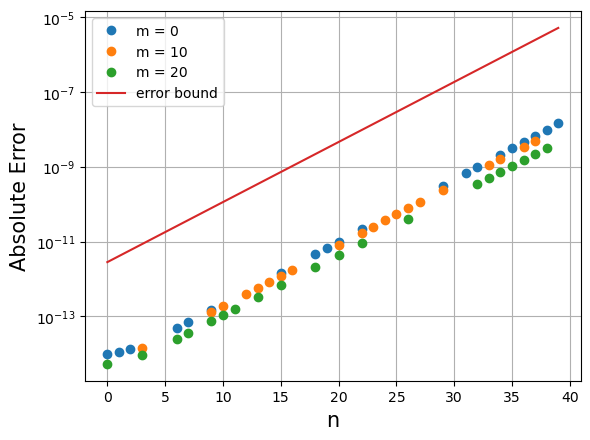

In [14]:
c_vec = [0.3, 0.3]
n_pts_vec = [20, 40]
m_vec = [0, 10, 20]
alpha_vec = [1.0,0.64]
n_sample = 10*2
AssessingErrorBatch(c_vec, alpha_vec, m_vec, n_sample, n_pts_vec)

In [15]:
def AssessingErrorInt(c, alpha, n, n_sample, n_pts = 1e10):
    distvec = np.random.choice(range(n_pts), n_sample - 1, replace=False)
    distvec = np.append(distvec, n_sample)

    vs = np.zeros(n_sample)
    for i in range(n_sample):
        tmp_m = distvec[i]
        #vv = eval_lgf(0.002, 0, tmp_m, 100000)
        vv = eval_lgf(c, alpha, tmp_m, n, 100000)
        vs[i] = vv

    resv = eval_lgf_rfft(c, alpha, n, n_pts)

    fv = np.real(resv)
    fv_part = fv[distvec]

    diff = np.abs((fv_part - vs))

    true_idx = np.argsort(distvec)
    sortedv = diff[true_idx]
    sortedidx = distvec[true_idx]

    eta = c**2/alpha * (1 - 0.01)**2
    M_eta = 1/2/np.sqrt(c**2/alpha - eta)
    gamma_eta = np.log(1 + eta/2 + np.sqrt((1 + eta/2)**2 - 1))
    min_m = min(distvec)
    max_m = max(distvec)
    m_space = np.linspace(min_m, max_m, n_pts)
    print('M_eta is ',M_eta)
    err_est = 2*M_eta/np.exp((2*n_pts - m_space)*gamma_eta)
    
    plt.semilogy(sortedidx, sortedv,'-o')
    
    plt.semilogy(m_space, err_est)

    #plt.semilogy(distvec, vs,'o')

    
    plt.legend(['Error', 'Error Bound'])

    plt.xlabel('m')
    plt.ylabel('Absolute Error')
    plt.minorticks_on()
    plt.grid(True, which='both')
    #plt.show()
    

M_eta is  250.62735355854278


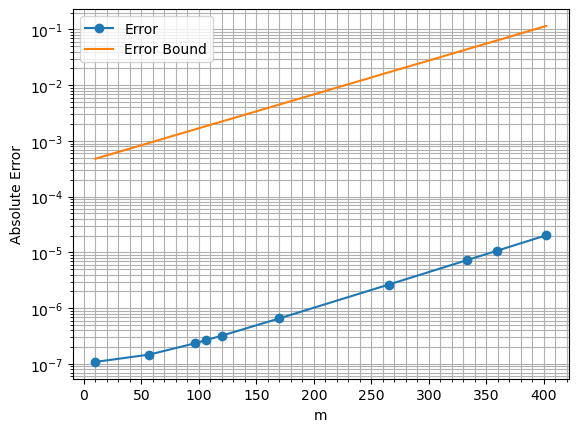

In [16]:
AssessingErrorInt(0.01, 0.5, 0, 10, 500)
#plt.savefig('Err_001_a_05_m_0_500_int.png')

In [19]:
def AssessingErrorBatchInt(c2a_vec, alpha_vec, m_vec, n_sample, npts_vec):
    #int this part, we fix c^2/alpha since the error bound only depend on that, however, we vary alpha
    #We use c2a = c*sqrt(alpha)
    for l, n_pts in enumerate(npts_vec):
        
        for i, c2a in enumerate(c2a_vec):
            alpha = alpha_vec[i]
            c = c2a*np.sqrt(alpha)
            plt.clf()
            plt.figure()

            

            
            max_n_all = 0
            min_n_all = n_pts+10
            #ax.yaxis.set_minor_formatter(FormatStrFormatter("%10d"))
            #ax.xaxis.set_minor_formatter(FormatStrFormatter("%4d"))
            
            
            for k, m in enumerate(m_vec):
                distvec = np.random.choice(range(n_pts), n_sample, replace=False)
                vs = np.zeros(n_sample)
                for i in range(n_sample):
                    tmp_n = distvec[i]
                    #vv = eval_lgf(0.002, 0, tmp_m, 100000)
                    vv = eval_lgf(c, alpha, tmp_n, m, 10000)
                    vs[i] = vv

                resv = eval_lgf_rfft(c, alpha, m, n_pts)

                fv = np.real(resv)
                fv_part = fv[distvec]

                diff = np.abs((fv_part - vs))

                true_idx = np.argsort(distvec)
                sortedv = diff[true_idx]
                sortedidx = distvec[true_idx]

                eta = c**2/alpha * (1 - 0.01)**2
                M_eta = 1/2/np.sqrt(c**2/alpha - eta)
                gamma_eta = np.log(1 + eta/2 + np.sqrt((1 + eta/2)**2 - 1))

                min_n = min(distvec)
                max_n = max(distvec)

                if max_n > max_n_all:
                    max_n_all = max_n

                if min_n < min_n_all:
                    min_n_all = min_n
                
                #print('M_eta is ',M_eta)
                name_str = "m = " + str(m)

                plt.semilogy(sortedidx, sortedv,'o',label=name_str)


            m_space = np.linspace(min_n_all, max_n_all, n_pts)
            eta = c**2/alpha * (1 - 0.01)**2
            M_eta = 1/2/np.sqrt(c**2/alpha - eta)
            print('M_eta is ',M_eta)
            gamma_eta = np.log(1 + eta/2 + np.sqrt((1 + eta/2)**2 - 1))
            print('gamma_eta is ',gamma_eta)

            err_est = 2*M_eta/np.exp((2*n_pts - m_space)*gamma_eta)
            plt.semilogy(m_space, err_est, label="error bound")
            plt.legend()
            plt.xlabel('n', fontsize=15)
            plt.ylabel(r'Absolute Error', fontsize=15)
            
            plt.grid(visible = True, which='major')
            plt.minorticks_off()

            figname_str = "Appell_comparison/Int_test_c2a_"+str(int(c2a*1000))+"_"+str(n_pts)+"_"+str(int(alpha*100))+".pdf"
            plt.savefig(figname_str)
                        

M_eta is  354.440602504168
gamma_eta is  0.00989995957131899
M_eta is  354.440602504168
gamma_eta is  0.00989995957131899
M_eta is  354.440602504168
gamma_eta is  0.00989995957131899
M_eta is  354.440602504168
gamma_eta is  0.00989995957131899


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

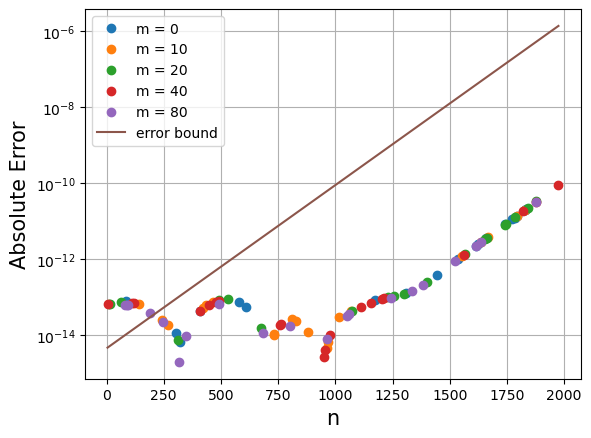

In [20]:
c_vec = [0.01, 0.01]
n_pts_vec = [1000, 2000]
m_vec = [0, 10, 20, 40, 80]
alpha_vec = [1, 0.64]
n_sample = 10*2
AssessingErrorBatchInt(c_vec, alpha_vec, m_vec, n_sample, n_pts_vec)

M_eta is  3544.4060250416783
gamma_eta is  0.00098999995953496


<Figure size 640x480 with 0 Axes>

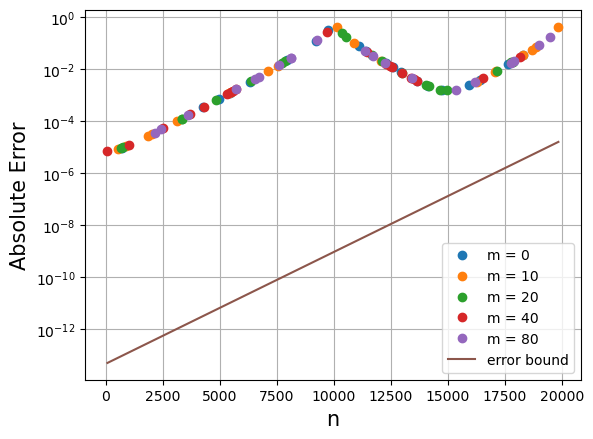

In [21]:
c_vec = [0.001]
n_pts_vec = [20000]
m_vec = [0, 10, 20, 40, 80]
alpha_vec = [0.64]
n_sample = 10*2
AssessingErrorBatchInt(c_vec, alpha_vec, m_vec, n_sample, n_pts_vec)